## This notebook simulates a flock of birds using the Boid model
### For test dataset: 
Instead of 1000 random initial conditions, we have just 50, each with a 20 different perturbation.
### For train dataset:
Same as before 300 random initial conditions.

#### create the dataset in pytorch format
Positions: (rollout steps ahead, number of boids, 2)
ex: (100 frames, 20 boids, 2 dimensions)

Species: a list of num_boid entries of each boid’s identity, (number of boids)
ex: ['goose', 'goose', 'crane', 'crane', 'crane']

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch_geometric.data import DataLoader

In [4]:
import sys
import os
script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [5]:
import os

from collab_env.data.file_utils import expand_path, get_project_root

# our code
from collab_env.sim.boids_gnn_temp.animal_simulation import (
    AnimalTrajectoryDataset, PerturbedTrajectoryDataset,
    visualize_graph,
)
from collab_env.sim.boids_gnn_temp.boid import (init_multi_species_boids, update_boids,
    perturb_initial_velocity,
    init_multi_species_boids,
    update_boids_with_food,
)
# %%


smoke_test = "CI" in os.environ
steps = 800 if not smoke_test else 10
save_file = True
num_samples = 1000 #1000
# %%

In [6]:
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 50,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,
        "margin": 5,  # 0.05, 25
        "turn_factor": 10,
        "speed_limit": 7,
        "counts": 20,
        "independent": False,
    }
}

In [7]:
save_file = True

In [8]:
perturb_spec = {"sigma": 0.005}

dataset = PerturbedTrajectoryDataset(
    init_multi_species_boids,
    perturb_initial_velocity,
    perturb_spec,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples=num_samples,
    num_perturb_per_sample = 20,
    seed=2025,
)

if save_file:

    torch.save(
        dataset,
        expand_path(
            "simulated_data/boid_perturbed.pt", get_project_root()
        ),
    )
    torch.save(
        species_configs,
        expand_path(
            "simulated_data/boid_perturbed_config.pt",
            get_project_root(),
        ),
    )


KeyboardInterrupt



### with food

In [11]:
width = 480
height = 480
independent = False

food_config = {"x": width / 3, "y": 0, "counts": 1}
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 60,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,  # 0.1, 0.5
        "margin": 20,  # 0.05, 25
        "turn_factor": 4,
        "speed_limit": 7,
        "food_factor": 0.05,  # 0.15, #0.05
        "food_visual_range": 200,
        "food_eating_range": 20,
        "food_time": 300,
        "hunger_threshold": -100,
        "counts": 20,
        "width": width,
        "height": height,
        "independent": independent,
        "food": food_config,
    },  # the food that species A can see
    "food0": food_config,
}

dataset = PerturbedTrajectoryDataset(
    init_multi_species_boids,
    perturb_initial_velocity,
    perturb_spec,
    update_boids_with_food,
    species_configs,
    width=width,
    height=height,
    steps=steps,
    num_samples=num_samples,
    num_perturb_per_sample = 20,
    seed=2025,
)

file_name = "boid_food_perturbed.pt"
config_name = "boid_food_perturbed_config.pt"

if save_file:
    torch.save(dataset, expand_path("simulated_data/" + file_name, get_project_root()))
    torch.save(
        species_configs,
        expand_path("simulated_data/" + config_name, get_project_root()),
    )

In [10]:
species_configs["A"]["matching_factor"] = 1

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples=50,
    seed=2025,
)

torch.save(
    dataset,
    expand_path(
        "simulated_data/boid_single_species_strong_alignment.pt", get_project_root()
    ),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_strong_alignment_config.pt",
        get_project_root(),
    ),
)

### Plot data

In [12]:
# file_name = 'boid_food_basic_alignment.pt'
# config_name = 'boid_food_basic_alignment_config.pt'

#file_name = "boid_single_species_basic.pt"
#config_name = "boid_single_species_basic_config.pt"

#file_name = 'boid_single_species_independent.pt'
#config_name = 'boid_single_species_independent_config.pt'

file_name = 'boid_perturbed.pt'
config_name = 'boid_perturbed_config.pt'


dataset = torch.load(
    expand_path("simulated_data/runpod/" + file_name, get_project_root()),
    weights_only=False,
)

species_configs = torch.load(
    expand_path("simulated_data/runpod/" + config_name, get_project_root()),
    weights_only=False,
)

In [13]:
batch_size = 1
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

batch = next(iter(loader))
p, species = batch

print("made", str(len(list(loader))), "batches, each of size", str(batch_size))  #
print("Positions:", p.shape)  # [B, steps, N, 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 1000 batches, each of size 1
Positions: torch.Size([1, 800, 20, 2])
Species labels: torch.Size([1, 20])




/workspace/conda/envs/collab-environment/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Visualize boids: boids are colored by the file they come from.

In [14]:
import matplotlib.pyplot as plt

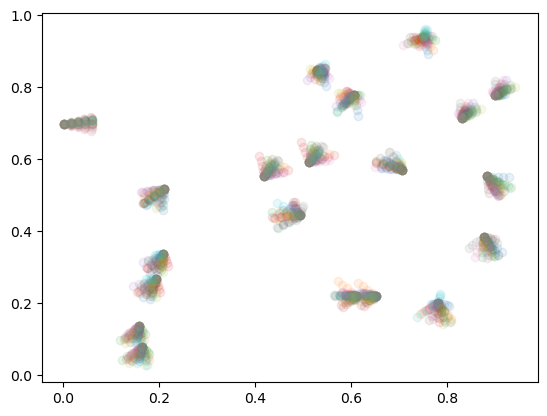

In [18]:
fig, ax = plt.subplots()

ind = 0
for file_id in range(0,20):
    ending_frame = 5
    batch = list(iter(loader))[file_id]
    p, species = batch
    p = p[0]
    v = torch.diff(p, dim=1)

    ind += 1
    ax.scatter(p[:ending_frame, :, 0], p[:ending_frame, :, 1], color="C"+str(file_id), alpha = 0.1)

In [11]:
p.shape

torch.Size([1, 100, 20, 2])

p0 shape torch.Size([20, 2])
p shape torch.Size([100, 20, 2])


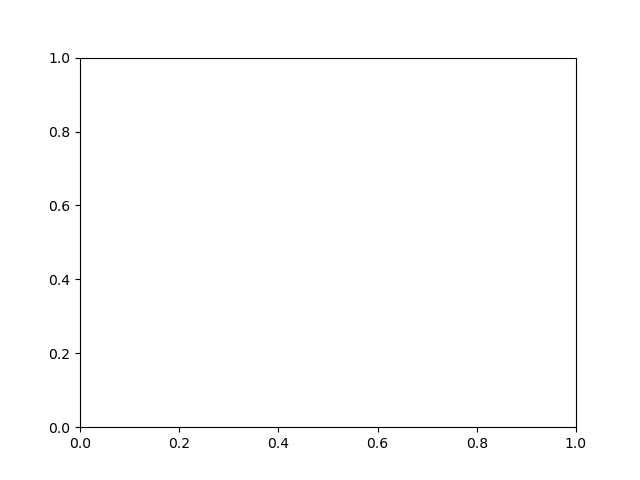

In [10]:
%matplotlib widget
global ani

file_id = 1
ending_frame = 200
batch = list(iter(loader))[file_id]
p, species = batch
v = torch.diff(p, dim=1)

_, F, _2, dim = p.shape
starting_frame = int(round(3 * F / 4))
ani, _ = visualize_graph(
    p[0, :ending_frame],
    v[0, :ending_frame],
    # species=species,
    batch=None,
    starting_frame=0,
    file_id=0,
    #ending_frame=200,
)

In [20]:
folder = "/workspace/collab-environment/figures/gnn/"

save_name = f"{folder}boid_food_independent_file{file_id}.gif"
ani.save(save_name, writer='imagemagick', fps=30)

MovieWriter imagemagick unavailable; using Pillow instead.
